# 1- Download the dataset


In [ ]:
%%shell
pip -q install --upgrade --no-cache-dir gdown
gdown --q 1KhpdnhlEiGJdL_oeBJlAYa865Vxgwzfv # csv file
echo 'download: done => file: archive.zip'
rm -rf ./segementation1/
unzip -q segementation1.zip

download: done => file: archive.zip


In [ ]:
image_folder = "/content/image"
label_folder = "/content/mask"

In [ ]:
import os

def count_files_in_folder(folder_path):
    # Lấy danh sách tên file trong thư mục
    file_names = os.listdir(folder_path)

    # Đếm số lượng file
    num_files = len(file_names)

    return num_files

# Đường dẫn đến thư mục cần đếm số file
folder_path = '/content/image'

# Gọi hàm để đếm số file trong thư mục
num_files = count_files_in_folder(folder_path)

# In ra kết quả
print(f"Số lượng file trong thư mục {folder_path}: {num_files}")

Số lượng file trong thư mục /content/image: 1500


# 2- Import libraries

In [ ]:
#basic libs
import os
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# machine learning libs
import tensorboard as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.utils as kutils

# for doing augmentation
import albumentations as A

# for integrating callbacks into training
from keras.callbacks import ModelCheckpoint, EarlyStopping


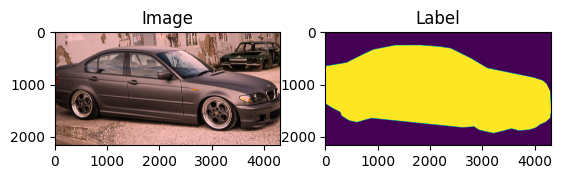

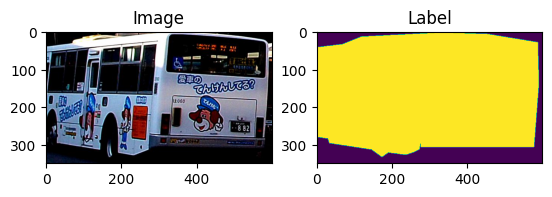

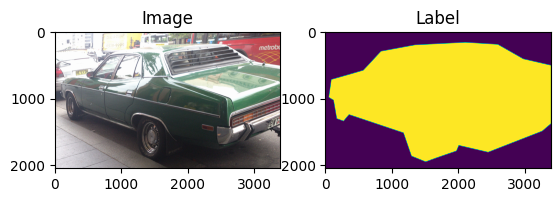

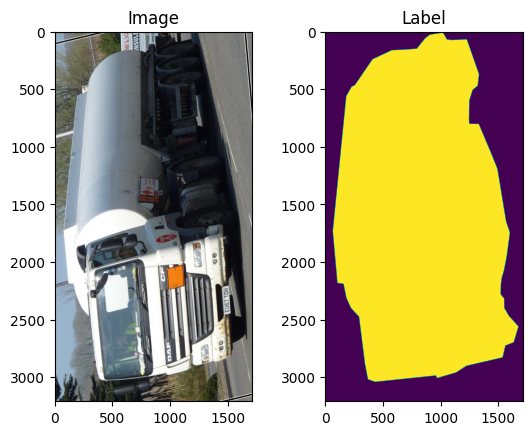

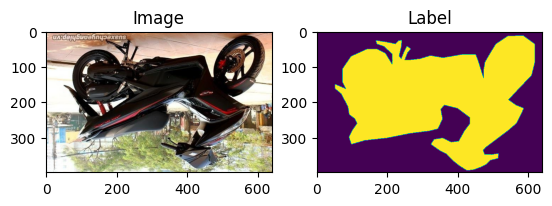

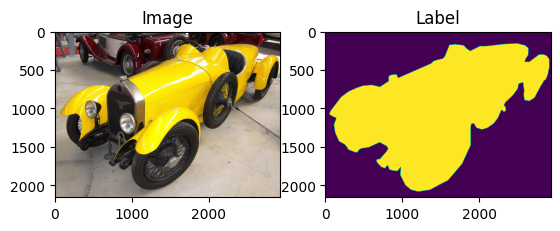

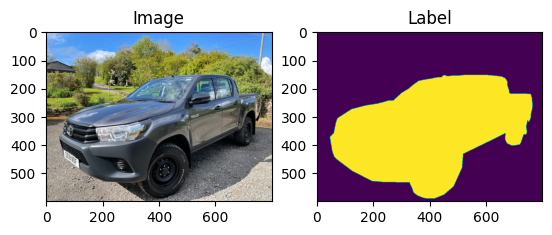

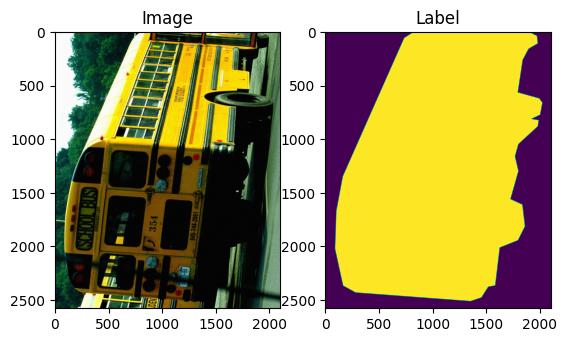

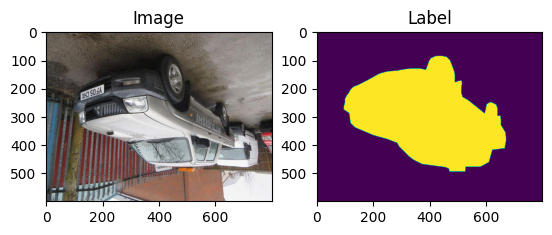

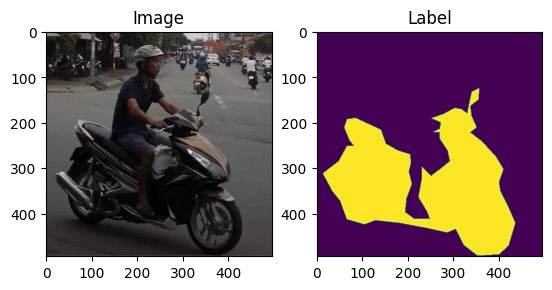

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

def show_images_from_directories(image_dir, label_dir, num_images=5):
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))

    # Chọn ngẫu nhiên các hình ảnh để hiển thị
    random_indices = random.sample(range(len(image_files)), num_images)

    for i in random_indices:
        image_file = image_files[i]
        label_file = label_files[i]

        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, label_file)

        image = Image.open(image_path)
        label = Image.open(label_path)

        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(image)
        axes[0].set_title('Image')
        axes[1].imshow(label)
        axes[1].set_title('Label')

        plt.show()

# Thư mục chứa ảnh và nhãn
image_folder = "/content/image"
label_folder = "/content/mask"

# Số lượng ảnh cần hiển thị
num_images_to_show = 10

# Hiển thị một số ảnh ngẫu nhiên từ hai thư mục
show_images_from_directories(image_folder, label_folder, num_images_to_show)


# 3- Define Dataset and Loader

## 3.1- Dataset

In [ ]:
from IPython.display import display_html
import random

label2color = {
    0: ("Background", [255, 255, 0]),
    1: ("Foreground", [0, 128, 0]),
    #"FP": ("False Positive", [255, 0, 0]),
   # "FN": ("False Negative", [0, 0, 255]),
}


class VehiclesDataset(object):
  def __init__(self, image_path=None, label_path=None, label_meaning:dict=None, name="VehiclesDataset"):
    self.__image_path = image_path
    self.__label_path = label_path
    self.__label_meaning = label_meaning
    self.__ds_name = name
    self.__image2label = None # Assign later

  def __update_image2label(self, image2label):
    self.__image2label = image2label

  def update(self):
    image_files = sorted(
      [
          fname
          for fname in os.listdir(self.__image_path)
          if fname.endswith(".jpg")
      ]
    )
    label_files = [fname[:-3] + "png" for fname in image_files]
    image_files = [os.path.join(self.__image_path, fname) for fname in image_files]
    label_files = [os.path.join(self.__label_path, fname) for fname in label_files]
    self.__image2label = dict(zip(image_files, label_files))
    return self

  def __len__(self):
    if(self.__image2label is None):
      raise Exception("Call 'update' after creating a dataset")

    return len(self.__image2label.keys())

  def __getitem__(self, idx):
    if idx >= len(self):
      raise Exception("Invalid index, greater than the last index ({})".format(len(self)))

    fn_images, fn_labels = self.get_all_files()
    return fn_images[idx], fn_labels[idx]

  def train_test_split(self, test_size=0.2, val_size=0.2, random_state=2023):
    all_image_files = list(self.__image2label.keys())
    random.Random(random_state).shuffle(all_image_files)

    ntests = int(len(all_image_files) * test_size)
    nvals = int(len(all_image_files) * val_size)

    train_image_files = all_image_files[:-ntests-nvals]
    train_label_files = [self.__image2label[k] for k in train_image_files]

    val_image_files = all_image_files[-ntests-nvals:-ntests]
    val_label_files = [self.__image2label[k] for k in val_image_files]

    test_image_files = all_image_files[-ntests:]
    test_label_files = [self.__image2label[k] for k in test_image_files]

    train_set = VehiclesDataset(self.__image_path, self.__label_path, self.__label_meaning, self.__ds_name + ": Training")
    train_set.__update_image2label(dict(zip(train_image_files, train_label_files)))

    val_set = VehiclesDataset(self.__image_path, self.__label_path, self.__label_meaning, self.__ds_name + ": Validation")
    val_set.__update_image2label(dict(zip(val_image_files, val_label_files)))

    test_set = VehiclesDataset(self.__image_path, self.__label_path, self.__label_meaning, self.__ds_name + ": Testing")
    test_set.__update_image2label(dict(zip(test_image_files, test_label_files)))

    return train_set, val_set, test_set



  def get_image2label(self):
    return self.__image2label

  def get_all_files(self):
    image_files = list(self.__image2label.keys())
    label_files = [self.__image2label[k] for k in image_files]
    return image_files, label_files

  def sample(self, nsamples=10):
    image_files = random.sample(list(self.__image2label.keys()), nsamples)
    label_files = [self.__image2label[fname] for fname in image_files]
    return image_files, label_files

  def load_images(self, image_files, label_files, shape=(200,200), colorized_label=True):
    # Read images and labels
    images, labels = [], []
    for k in range(len(image_files)):
      if shape is not None:
        image = np.asarray(kutils.load_img(image_files[k], target_size=shape, color_mode='rgb'))
        label = np.asarray(kutils.load_img(label_files[k], target_size=shape, color_mode='grayscale'))
        #print("label dtype:{0}, min: {1}, max: {2} ".format(str(label.dtype), label.min(), label.max()))
      else:
        image = np.asarray(kutils.load_img(image_files[k], color_mode='rgb'))
        label = np.asarray(kutils.load_img(label_files[k], color_mode='grayscale'))

      #label = label - 1 # 1-based => 0-based

      images.append(image)
      labels.append(label)

    # Transform labels
    if colorized_label:
        color_labels = []
        for label in labels:
          color_label = np.zeros((*label.shape,3), dtype=np.uint8)
          for k in self.__label_meaning.keys():
            color_label[label == k] = self.__label_meaning[k][1]
          color_labels.append(color_label)
        labels = color_labels

    return images, labels

  def describe(self, nsamples=10):
        print("="*150)
        print("Dataset: {0}".format(self.__ds_name))
        print("Number samples: {0}".format(len(self)))
        print("Meaning of labels: ")
        print(self.__label_meaning)
        print("Some files in this dataset:")
        print()
        print("-"*150)

        image_files, label_files = self.sample(nsamples)
        image_shapes = [cv2.imread(fname, 1).shape for fname in image_files]
        label_shapes = [cv2.imread(fname, 0).shape for fname in label_files]
        frame = pd.DataFrame({
            "Image Files": image_files,
            "Image Shapes": image_shapes,
            "Label Files": label_files,
            "Label Shapes": label_shapes,
        })
        display_html(frame._repr_html_(), raw=True)
        print("="*150)

        for image_file, label_file in zip(image_files, label_files):
            # Read image and label
            image = cv2.imread(image_file, 1)
            label = cv2.imread(label_file, 0)

            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(image)
            axes[0].set_title(f"Image: {os.path.basename(image_file)}")
            axes[1].imshow(label)
            axes[1].set_title(f"Label: {os.path.basename(label_file)}")

            plt.show()

        print("="*150)


## 3.2- Loader
* Library for doing augmentation:
[https://albumentations.ai/docs/getting_started/mask_augmentation/](https://albumentations.ai/docs/getting_started/mask_augmentation/)

In [ ]:
import albumentations as A
class DataLoader(keras.utils.Sequence):
  def __init__(self, dataset:VehiclesDataset, batch_size=50, image_sizes=(128, 128), shuffle=True, augmented=True):
    self.__dataset = dataset
    self.__batch_size = batch_size
    self.__image_sizes = image_sizes
    self.__loaded_sizes = [int(s*1.2)for s in image_sizes] # load with 20% bigger and then crop
    self.__image2label = dataset.get_image2label()
    self.__augmented = augmented
    self.__prepare(shuffle)

  def __prepare(self, shuffle=True):
    self.__image_files = list(self.__image2label.keys())
    if shuffle:
      self.__image_files = random.sample(self.__image_files, len(self.__image_files))

  def __len__(self):
    return len(self.__dataset) // self.__batch_size

  def __do_augmentation(self, images, labels, image_sizes=(208, 208)):
    transform = A.Compose([
        A.RandomCrop(height=image_sizes[0], width=image_sizes[1], p=1.0),
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.OneOf([
          A.RandomRotate90(p=0.5),
          A.Rotate(p=0.5)
        ], p=0.5)
    ])
    transformed_images = []
    transformed_masks = []
    for k in range(len(images)):
      image = images[0, ...]
      mask = np.squeeze(labels[0, ...])
      transformed = transform(image=image, mask=mask)
      transformed_images.append(np.expand_dims(transformed['image'], axis=0))
      transformed_masks.append(np.expand_dims(transformed['mask'], axis=0))
    return np.concatenate(transformed_images, axis=0), np.expand_dims(np.concatenate(transformed_masks, axis=0), axis=-1)

  def __getitem__(self, batch_idx):
    start_idx = batch_idx * self.__batch_size
    end_idx = min(start_idx + self.__batch_size, len(self.__image_files) - 1)
    fn_images = self.__image_files[start_idx: end_idx]
    fn_labels = [self.__image2label[k] for k in fn_images]

    images, labels = self.__dataset.load_images(fn_images, fn_labels, shape=self.__image_sizes, colorized_label=False)
    # Comabine to batch
    images = np.concatenate([np.expand_dims(image, axis=0) for image in images], axis=0)
    labels = np.concatenate([np.expand_dims(np.expand_dims(label, axis=-1), axis=0) for label in labels], axis=0)
    return images, labels

## 3.3 Testing the dataset and the loader

### 3.3.1- for dataset

In [ ]:
if os.path.exists(image_folder):
    print("Thư mục hình ảnh tồn tại")
else:
    print("Thư mục hình ảnh không tồn tại")

if os.path.exists(label_folder):
    print("Thư mục nhãn tồn tại")
else:
    print("Thư mục nhãn không tồn tại")

Thư mục hình ảnh tồn tại
Thư mục nhãn tồn tại


Dataset: VehiclesDataset
Number samples: 1500
Meaning of labels: 
{0: ('Background', [255, 255, 0]), 1: ('Foreground', [0, 128, 0])}
Some files in this dataset:

------------------------------------------------------------------------------------------------------------------------------------------------------


Image Files 
 Image Shapes 
 Label Files 
 Label Shapes 
 
 
 
 
 0 
 /content/image/xetai_56_180.jpg 
 (1111, 1600, 3) 
 /content/mask/xetai_56_180.png 
 (1111, 1600) 
 
 
 1 
 /content/image/xetai_65_90.jpg 
 (723, 563, 3) 
 /content/mask/xetai_65_90.png 
 (723, 563) 
 
 
 2 
 /content/image/xetai_84.jpg 
 (706, 1251, 3) 
 /content/mask/xetai_84.png 
 (706, 1251) 
 
 
 3 
 /content/image/xetai_15_180.jpg 
 (841, 1480, 3) 
 /content/mask/xetai_15_180.png 
 (841, 1480) 
 
 
 4 
 /content/image/xetai_5_180.jpg 
 (1086, 1770, 3) 
 /content/mask/xetai_5_180.png 
 (1086, 1770) 
 
 
 5 
 /content/image/xetai_42_180.jpg 
 (1944, 3492, 3) 
 /content/mask/xetai_42_180.png 
 (1944, 3492) 
 
 
 6 
 /content/image/xehoi_29_180.jpg 
 (2091, 3596, 3) 
 /content/mask/xehoi_29_180.png 
 (2091, 3596) 
 
 
 7 
 /content/image/xemay_618.jpg 
 (506, 900, 3) 
 /content/mask/xemay_618.png 
 (506, 900) 
 
 
 8 
 /content/image/xehoi_9_180.jpg 
 (1994, 4141, 3) 
 /content/mask/xehoi_9_180.png 
 (1994, 4141) 
 
 
 9 
 /content/image/xemay_691_90.jpg 
 (259, 194, 3) 
 /content/mask/xemay_691_90.png 
 (259, 194)

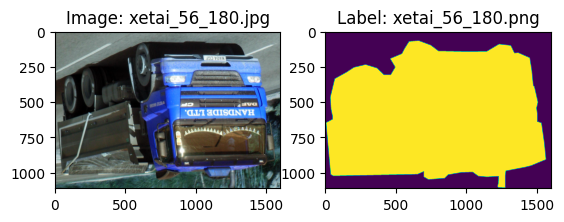

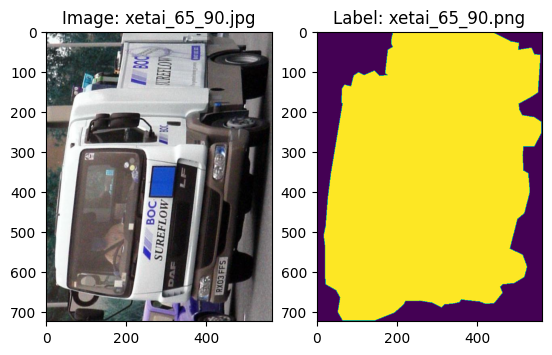

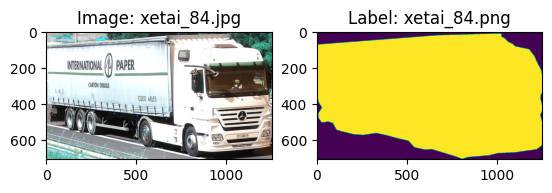

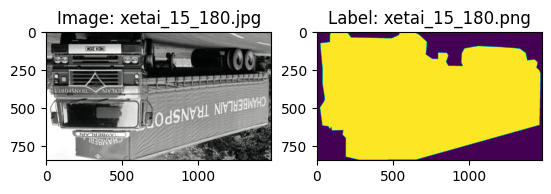

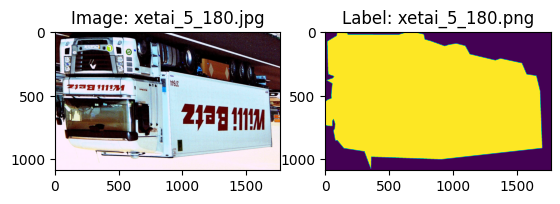

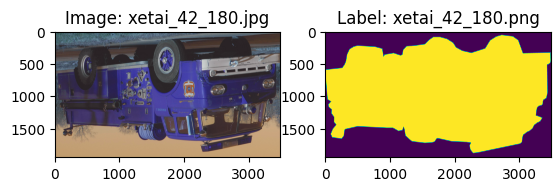

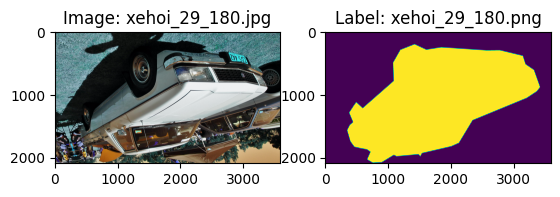

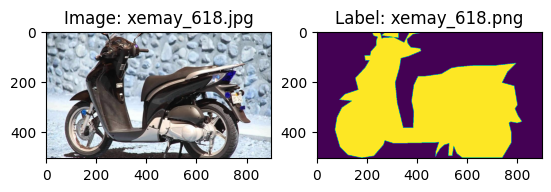

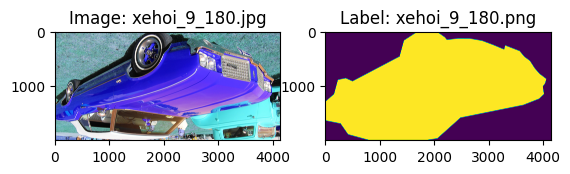

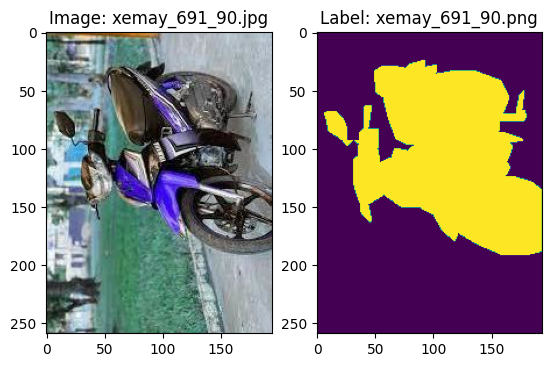

In [ ]:
#Pixel Annotations: 1: Foreground 2:Background 3: Not classified
ds = VehiclesDataset(image_folder, label_folder, label2color, "VehiclesDataset").update()
ds.describe()

In [ ]:
train_set, test_set, val_set = ds.train_test_split(test_size=0.1, val_size=0.1)

Dataset: VehiclesDataset: Training
Number samples: 1200
Meaning of labels: 
{0: ('Background', [255, 255, 0]), 1: ('Foreground', [0, 128, 0])}
Some files in this dataset:

------------------------------------------------------------------------------------------------------------------------------------------------------


Image Files 
 Image Shapes 
 Label Files 
 Label Shapes 
 
 
 
 
 0 
 /content/image/xemay_845.jpg 
 (469, 500, 3) 
 /content/mask/xemay_845.png 
 (469, 500) 
 
 
 1 
 /content/image/xehoi_56_90.jpg 
 (3148, 2558, 3) 
 /content/mask/xehoi_56_90.png 
 (3148, 2558) 
 
 
 2 
 /content/image/xebantai_50_180.jpg 
 (600, 800, 3) 
 /content/mask/xebantai_50_180.png 
 (600, 800) 
 
 
 3 
 /content/image/xetai_56.jpg 
 (1111, 1600, 3) 
 /content/mask/xetai_56.png 
 (1111, 1600) 
 
 
 4 
 /content/image/xebantai_13_90.jpg 
 (800, 600, 3) 
 /content/mask/xebantai_13_90.png 
 (800, 600) 
 
 
 5 
 /content/image/xebantai_69_180.jpg 
 (600, 800, 3) 
 /content/mask/xebantai_69_180.png 
 (600, 800) 
 
 
 6 
 /content/image/xetai_80_90.jpg 
 (2138, 1528, 3) 
 /content/mask/xetai_80_90.png 
 (2138, 1528) 
 
 
 7 
 /content/image/xetai_62.jpg 
 (2488, 3303, 3) 
 /content/mask/xetai_62.png 
 (2488, 3303) 
 
 
 8 
 /content/image/xehoi_7.jpg 
 (2340, 3446, 3) 
 /content/mask/xehoi_7.png 
 (2340, 3446) 
 
 
 9 
 /content/image/xehoi_14_90.jpg 
 (3443, 2168, 3) 
 /content/mask/xehoi_14_90.png 
 (3443, 2168)

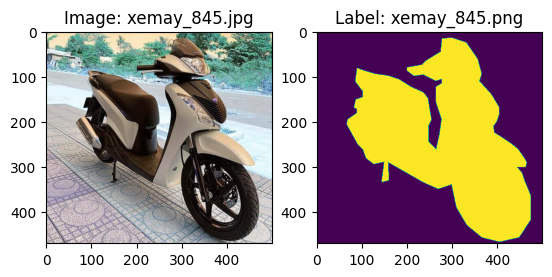

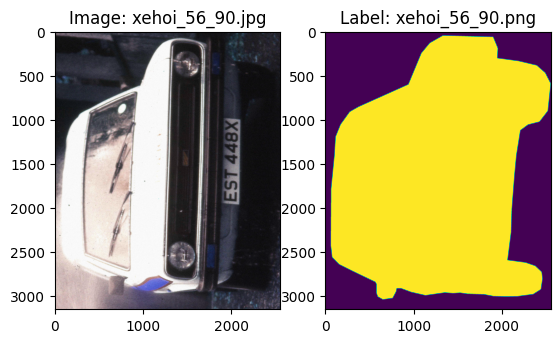

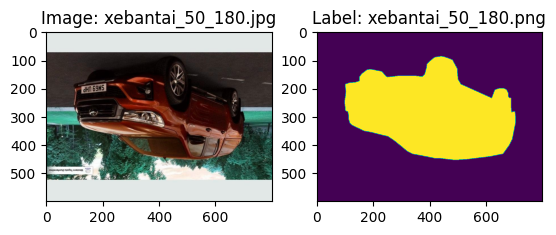

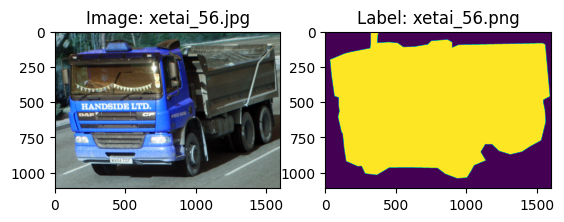

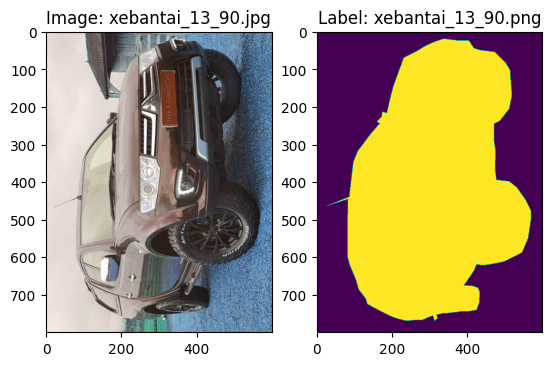

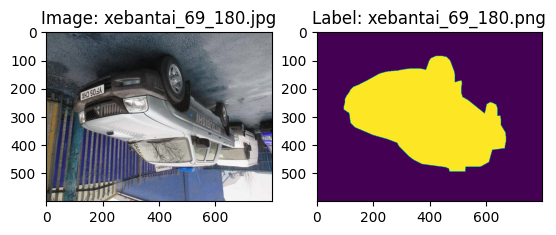

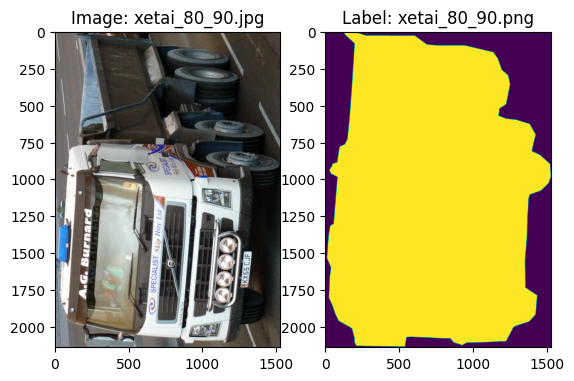

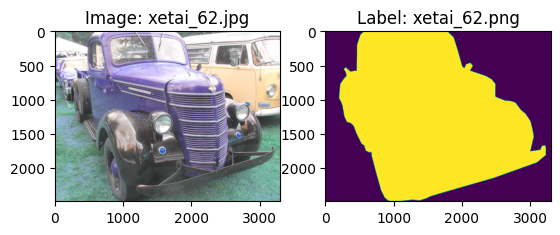

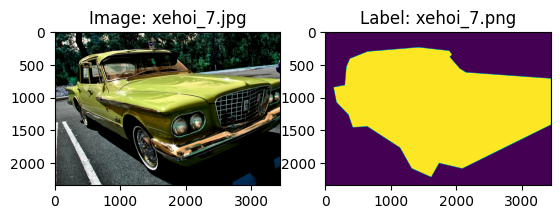

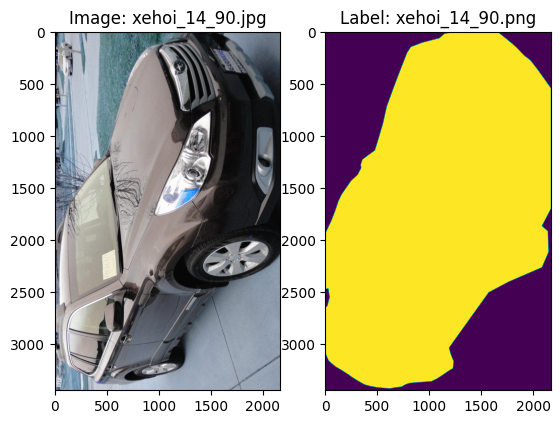

In [ ]:
train_set.describe()

Dataset: VehiclesDataset: Validation
Number samples: 150
Meaning of labels: 
{0: ('Background', [255, 255, 0]), 1: ('Foreground', [0, 128, 0])}
Some files in this dataset:

------------------------------------------------------------------------------------------------------------------------------------------------------


Image Files 
 Image Shapes 
 Label Files 
 Label Shapes 
 
 
 
 
 0 
 /content/image/xemay_534_90.jpg 
 (728, 546, 3) 
 /content/mask/xemay_534_90.png 
 (728, 546) 
 
 
 1 
 /content/image/xetai_3.jpg 
 (914, 1569, 3) 
 /content/mask/xetai_3.png 
 (914, 1569) 
 
 
 2 
 /content/image/xebantai_65_90.jpg 
 (800, 600, 3) 
 /content/mask/xebantai_65_90.png 
 (800, 600) 
 
 
 3 
 /content/image/xebus_90_180.jpg 
 (1776, 2388, 3) 
 /content/mask/xebus_90_180.png 
 (1776, 2388) 
 
 
 4 
 /content/image/xetai_16_90.jpg 
 (3112, 1580, 3) 
 /content/mask/xetai_16_90.png 
 (3112, 1580) 
 
 
 5 
 /content/image/xebantai_80.jpg 
 (600, 800, 3) 
 /content/mask/xebantai_80.png 
 (600, 800) 
 
 
 6 
 /content/image/xebantai_84_180.jpg 
 (600, 800, 3) 
 /content/mask/xebantai_84_180.png 
 (600, 800) 
 
 
 7 
 /content/image/xebantai_10_180.jpg 
 (600, 800, 3) 
 /content/mask/xebantai_10_180.png 
 (600, 800) 
 
 
 8 
 /content/image/xemay_8_90.jpg 
 (660, 450, 3) 
 /content/mask/xemay_8_90.png 
 (660, 450) 
 
 
 9 
 /content/image/xebus_13.jpg 
 (707, 962, 3) 
 /content/mask/xebus_13.png 
 (707, 962)

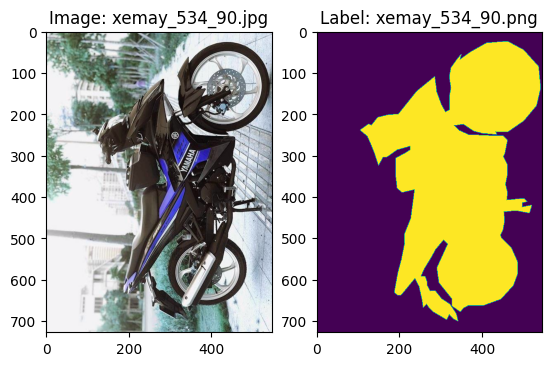

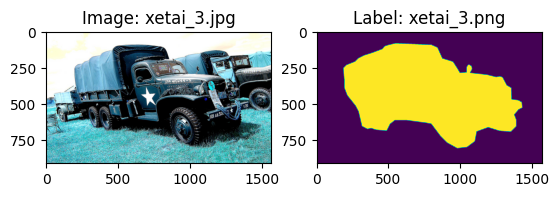

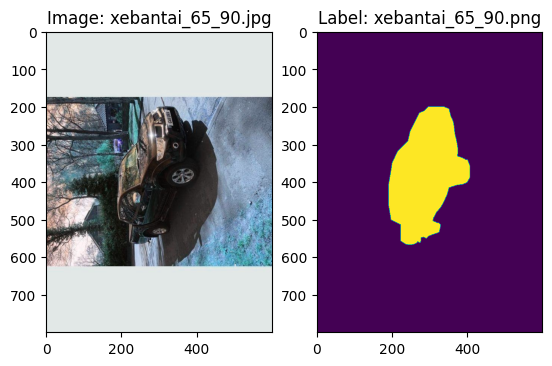

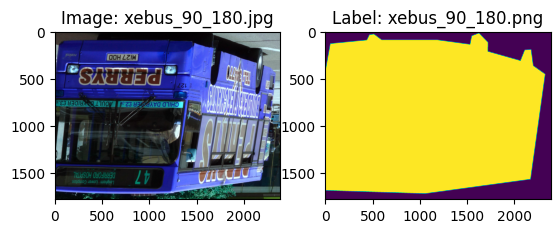

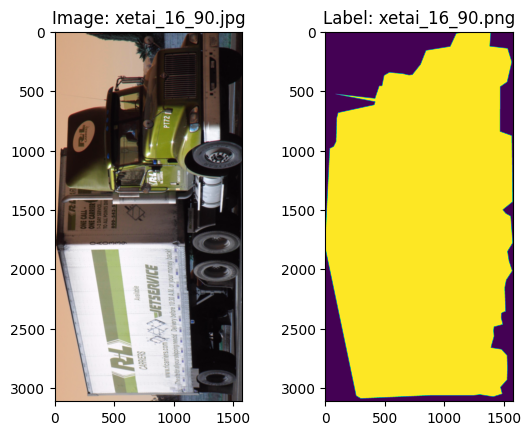

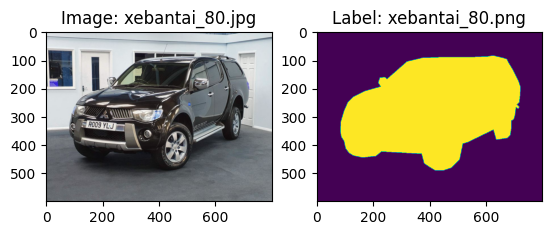

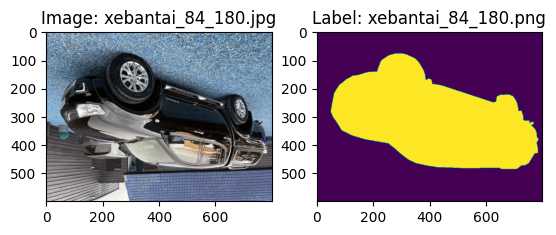

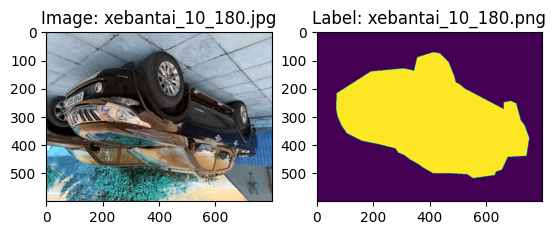

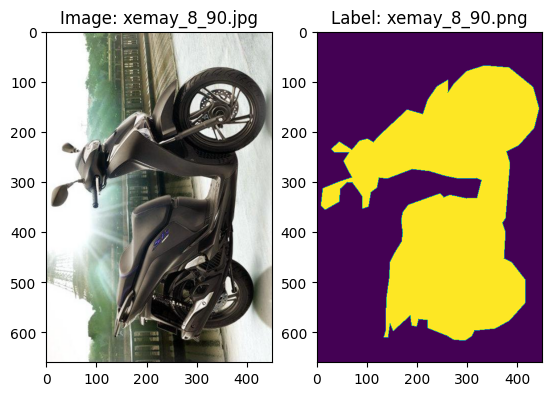

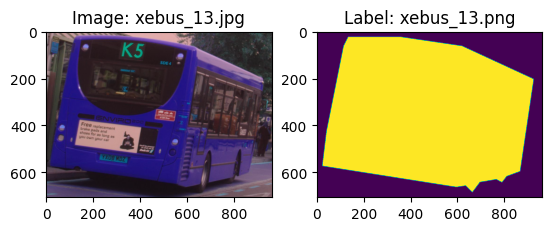

In [ ]:
test_set.describe()

Dataset: VehiclesDataset: Testing
Number samples: 150
Meaning of labels: 
{0: ('Background', [255, 255, 0]), 1: ('Foreground', [0, 128, 0])}
Some files in this dataset:

------------------------------------------------------------------------------------------------------------------------------------------------------


Image Files 
 Image Shapes 
 Label Files 
 Label Shapes 
 
 
 
 
 0 
 /content/image/xetai_38.jpg 
 (1301, 1536, 3) 
 /content/mask/xetai_38.png 
 (1301, 1536) 
 
 
 1 
 /content/image/xebantai_26_180.jpg 
 (600, 800, 3) 
 /content/mask/xebantai_26_180.png 
 (600, 800) 
 
 
 2 
 /content/image/xetai_67_180.jpg 
 (719, 1688, 3) 
 /content/mask/xetai_67_180.png 
 (719, 1688) 
 
 
 3 
 /content/image/xehoi_26.jpg 
 (2142, 3731, 3) 
 /content/mask/xehoi_26.png 
 (2142, 3731) 
 
 
 4 
 /content/image/xetai_1_180.jpg 
 (1619, 3749, 3) 
 /content/mask/xetai_1_180.png 
 (1619, 3749) 
 
 
 5 
 /content/image/xebus_4_180.jpg 
 (2675, 2496, 3) 
 /content/mask/xebus_4_180.png 
 (2675, 2496) 
 
 
 6 
 /content/image/xebus_42.jpg 
 (547, 733, 3) 
 /content/mask/xebus_42.png 
 (547, 733) 
 
 
 7 
 /content/image/xebantai_96_180.jpg 
 (600, 800, 3) 
 /content/mask/xebantai_96_180.png 
 (600, 800) 
 
 
 8 
 /content/image/xebus_42_180.jpg 
 (547, 733, 3) 
 /content/mask/xebus_42_180.png 
 (547, 733) 
 
 
 9 
 /content/image/xetai_88_90.jpg 
 (2481, 1904, 3) 
 /content/mask/xetai_88_90.png 
 (2481, 1904)

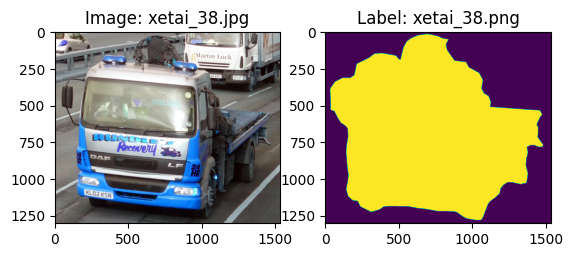

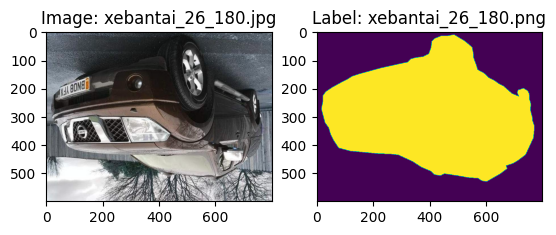

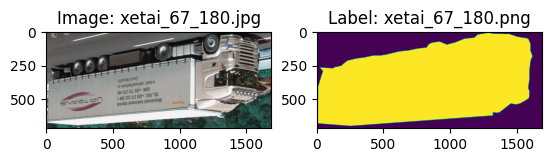

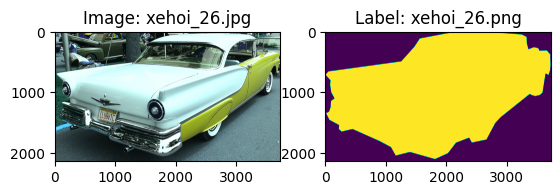

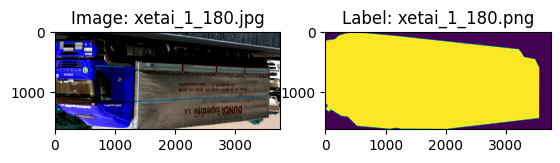

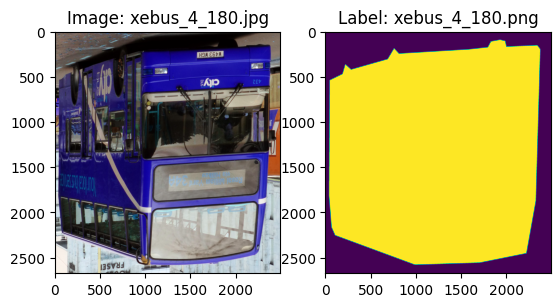

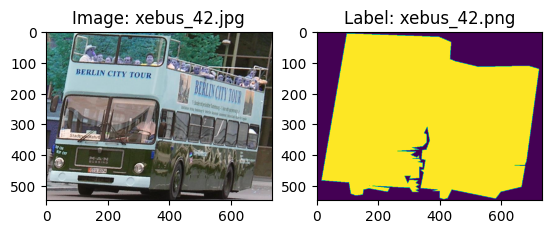

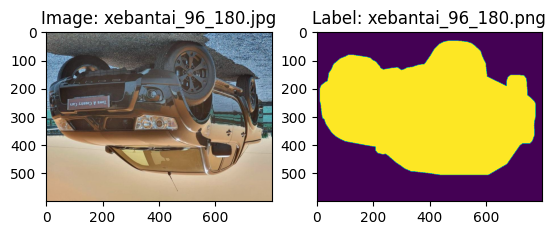

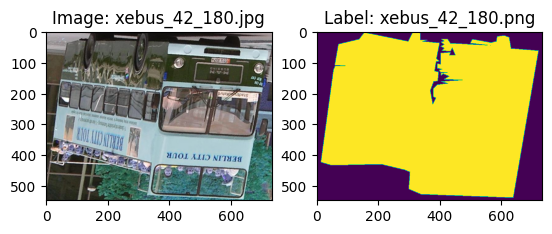

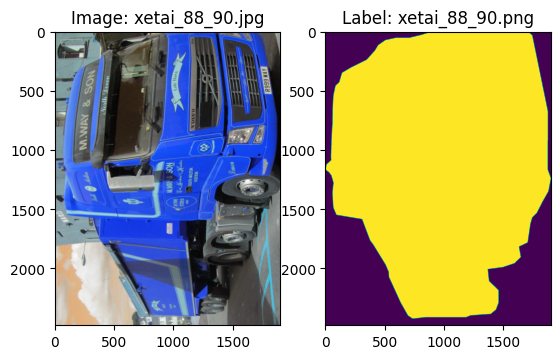

In [ ]:
val_set.describe()

### 3.3.2 for loader

In [ ]:
loader = DataLoader(train_set, batch_size=128, image_sizes=(128, 128))
for batch_images, batch_labels in loader:
  print(batch_images.shape)
  print(batch_labels.shape)
  print(batch_labels.min(), batch_labels.max(), batch_labels.dtype)
  print(batch_images.min(), batch_images.max(), batch_labels.dtype)
  break

(128, 128, 128, 3)
(128, 128, 128, 1)
0 1 uint8
0 255 uint8


# 4- Define the Unet model

## 4.1- Select hyper-parameters

In [ ]:
image_sizes = (128, 128) #H,W: in multiple of 16
num_classes = 2

## 4.2- Version-1: Encoder and Decoder Connected

## 4.3 Version-2: UNET2D-Like

#Bài 1:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Add

# Sử dụng glorot_uniform cho khởi tạo trọng số

#Bài 2:

In [ ]:
def double_conv_block(x, num_filters):
    # Double convolution block: Convolution -> ReLU -> Convolution -> ReLU

    # Conv2D then ReLU activation
    x = layers.Conv2D(num_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(num_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x


#Bài 3:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers

def downsampling_block(x, num_filters):
    f = double_conv_block(x, num_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

#Bài 4

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose

def upsampling_block(x, skip_connection, num_filters):
    # upsample
    x = layers.Conv2DTranspose(num_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, skip_connection])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, num_filters)

    return x



#Bài 5

In [ ]:
def U_NET(width, height, channels, n_classes):
    # Encoder
    inputs = layers.Input((height, width, channels))

    s1, p1 = downsampling_block(inputs, 64)
    s2, p2 = downsampling_block(p1, 128)
    s3, p3 = downsampling_block(p2, 256)
    s4, p4 = downsampling_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u1 = upsampling_block(bottleneck, s4, 512)
    u2 = upsampling_block(u1, s3, 256)
    u3 = upsampling_block(u2, s2, 128)
    u4 = upsampling_block(u3, s1, 64)

    outputs = Conv2D(n_classes, 1, padding="same", activation='softmax')(u4)

    unet_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="U-Net")

    return unet_model

if __name__ == "__main__":
    model_unet = U_NET(128, 128, 3, 2)
    print(model_unet.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

# 5- Train the model

In [ ]:
# Select model (version)
model = model_unet

# Create loaders for the train and the test set
train_loader = DataLoader(train_set, batch_size=50, image_sizes=image_sizes, shuffle=True, augmented=True)

val_loader = DataLoader(val_set, batch_size=50, image_sizes=image_sizes, shuffle=False)

test_loader = DataLoader(test_set, batch_size=50, image_sizes=image_sizes, shuffle=False)



# Sử dụng Adam optimizer với weight decay
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08, clipnorm=1.0)

#############################################################################################
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("{0}.h5".format(model.name), save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 100
H = model.fit(train_loader, epochs=epochs, validation_data=val_loader, callbacks=callbacks)


Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 33.0663 - accuracy: 0.3646

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 101s 3s/step - loss: 33.0663 - accuracy: 0.3646 - val_loss: 0.6311 - val_accuracy: 0.2340
Epoch 2/100
24/24 [==============================] - 53s 2s/step - loss: 0.5794 - accuracy: 0.2420 - val_loss: 0.4929 - val_accuracy: 0.3042
Epoch 3/100
24/24 [==============================] - 57s 2s/step - loss: 0.4876 - accuracy: 0.3737 - val_loss: 0.4689 - val_accuracy: 0.4180
Epoch 4/100
24/24 [==============================] - 55s 2s/step - loss: 0.4537 - accuracy: 0.3901 - val_loss: 0.4328 - val_accuracy: 0.4465
Epoch 5/100
24/24 [==============================] - 48s 2s/step - loss: 0.4255 - accuracy: 0.4087 - val_loss: 0.4571 - val_accuracy: 0.5054
Epoch 6/100
24/24 [==============================] - 55s 2s/step - loss: 0.4283 - accuracy: 0.4220 - val_loss: 0.4182 - val_accuracy: 0.4254
Epoch 7/100
24/24 [==============================] - 49s 2s/step - loss: 0.4168 - accuracy: 0.4219 - val_loss: 0.4332 - val_accuracy: 0.3807
Epoch 8/100
24/24 [====

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


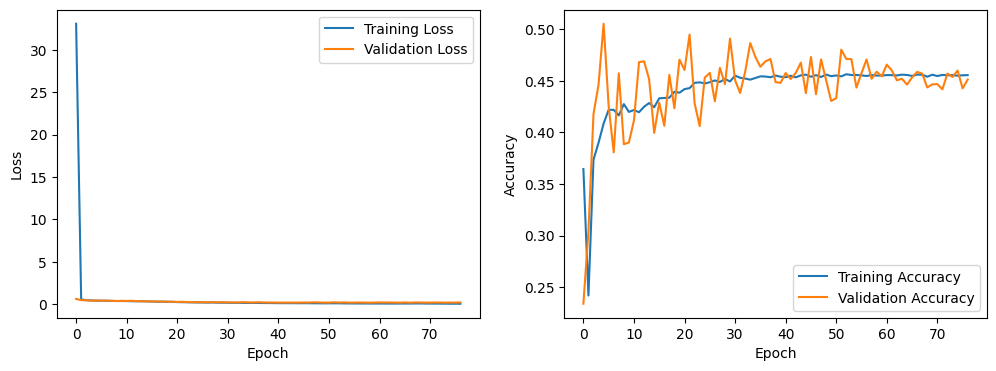

In [ ]:
# Plot training loss and accuracy
print(H.history.keys())
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

3/3 [==============================] - 4s 1s/step - loss: 0.2147 - accuracy: 0.4578
Test Loss: 0.2147, Test Accuracy: 45.78%


# 6- Evaluate the model (qualitative)

## 6.1- Metrics

In [ ]:
def decode_segmentation(y_true, y_pred, label2color:dict):
  image = np.zeros((*y_true.shape, 3), dtype=np.uint8)

  labels = list(filter(lambda x: isinstance(x, int), list(label2color.keys())))
  labels = list(filter(lambda x: label2color[x][0].lower() != "background", labels))

  for k in labels:
    label_mask = y_true == k
    pred_mask = y_pred == k
    tp = label_mask & pred_mask

    image[tp] = label2color[k][1]
  return image

## 6.2- Qualitative

2/2 [==============================] - 7s 3s/step


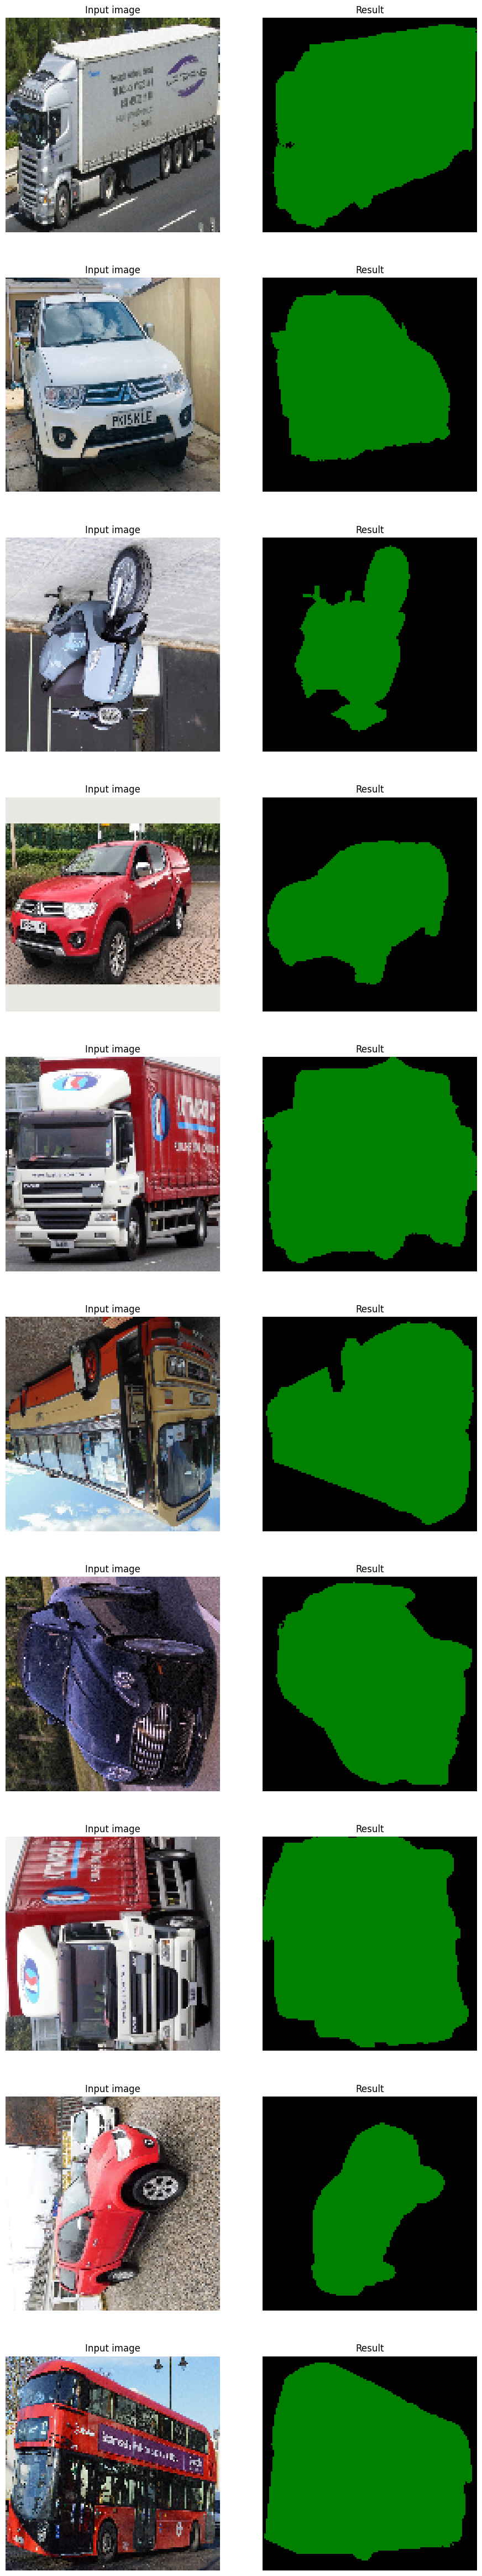

In [ ]:
def display_segments(images, labels, preds, num=5):
  num = min(num, images.shape[0])

  images = images[:num, ...]
  labels = labels[:num, ...]
  preds = preds[:num, ...]

  plt.figure(figsize=(11,num*6))
  for k in range(num):
    ax = plt.subplot(num,2, 2*k + 1)
    ax.imshow(images[k])
    ax.set_axis_off()
    ax.set_title('Input image')

    ax = plt.subplot(num,2, 2*k + 2)
    ax.imshow(decode_segmentation(labels[k], preds[k] , label2color))
    ax.set_axis_off()
    ax.set_title('Result')
  plt.show()

batch_idx = random.randint(0, len(test_loader))
images, labels = test_loader[batch_idx]
preds = model.predict(images)
preds = np.argmax(preds, axis=-1)
labels = labels.squeeze()
display_segments(images, labels, preds, num=10)

1/1 [==============================] - 0s 129ms/step


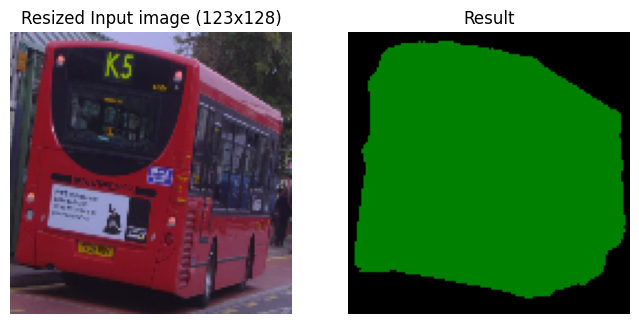

In [ ]:
def display_single_segment(image, model, label2color: dict):
    # Resize the image to the desired size (123x128)
    resized_image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_NEAREST)

    pred = model.predict(np.expand_dims(resized_image, axis=0))
    pred = np.argmax(pred, axis=-1)[0]

    plt.figure(figsize=(8, 4))

    ax = plt.subplot(1, 2, 1)
    ax.imshow(resized_image)
    ax.set_axis_off()
    ax.set_title('Resized Input image (123x128)')

    ax = plt.subplot(1, 2, 2)
    ax.imshow(decode_segmentation(pred, pred, label2color))
    ax.set_axis_off()
    ax.set_title('Result')

    plt.show()

# Load an external image
external_image_path = '/content/image/xebus_13.jpg'
external_image = cv2.imread(external_image_path)
external_image = cv2.cvtColor(external_image, cv2.COLOR_BGR2RGB)  # Ensure the image is in RGB format

# Display the segmentation result for the resized external image
display_single_segment(external_image, model, label2color)
